In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [121]:
from sklearn import linear_model

In [2]:
from julia.api import Julia
Julia(compiled_modules=False)
from julia import Main

In [3]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [4]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.18.4
Running on torch: v1.6.0
Running on sbi: v0.12.2


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
cwd = os.getcwd()
cwd

'/data/SBI/MPR_SBI'

In [8]:
Res_dir='Res_SBI_MPR_aged_inferAlphaG_numsim1k'

#### functions for visualization

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
def add_colorbar(fig, ax, im=None, vmin=None, vmax=None, position='right', size='1%',pad=0.3, **cbar_kwargs):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position, size=size, pad=pad)
    if im is None:
        norm = colors.Normalize()
        im = plt.cm.ScalarMappable(norm=norm)
    if vmin is not None or vmax is not None:
        im.set_clim(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, **cbar_kwargs)
    return cbar

#### load MPR.jl

In [10]:
MPR=Main.include("MPR.jl")
MPR

<PyCall.jlwrap MPR>

### load SC

First let's look at the weights matrix for the original subject, and the applied mask. Here the scaling coefficient is $\alpha=0.5$.

In [11]:
import sbi_julia
sbi_julia_path = os.path.dirname(os.path.dirname(sbi_julia.__file__))
SC_healthy=np.loadtxt(sbi_julia_path+ '/data_input_files/SCjulichmax.txt', delimiter=',',  unpack=True)
MaskJulichA= np.loadtxt(sbi_julia_path+ '/data_input_files/MaskJulichA.txt', delimiter=',',  unpack=True)
MaskJulichB= np.loadtxt(sbi_julia_path+ '/data_input_files/MaskJulichB.txt', delimiter=',',  unpack=True)

In [12]:
SC_healthy.shape, MaskJulichA.shape, MaskJulichB.shape

((400, 400), (400, 400), (400, 400))

In [13]:
SC_healthy.min(), SC_healthy.max()

(0.0, 1.0)

In [14]:
MaskJulichA.min(), MaskJulichA.max()

(0.0, 0.85741)

In [15]:
MaskJulichB.min(), MaskJulichB.max()

(0.0, 0.26523)

In [16]:
alpha=0.5
beta =0.0

In [17]:
SC_aged=SC_healthy-(alpha*MaskJulichA)-(beta*MaskJulichB)

In [18]:
SC_aged.shape, SC_aged.min(), SC_aged.max()

((400, 400), 0.0, 1.0)

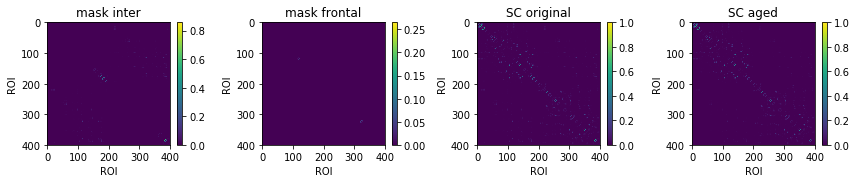

In [19]:
fig, axs = plt.subplots(ncols=4, figsize=(12,8))

ax = axs[0]
im = ax.imshow(MaskJulichA)
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='mask inter', ylabel='ROI', xlabel='ROI')

ax = axs[1]
im = ax.imshow(MaskJulichB)
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='mask frontal', ylabel='ROI', xlabel='ROI')


ax = axs[2]
im = ax.imshow(SC_healthy)
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='SC original', ylabel='ROI', xlabel='ROI')

ax = axs[3]
im = ax.imshow(SC_aged)
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='SC aged', ylabel='ROI', xlabel='ROI')

fig.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCdata.png"))


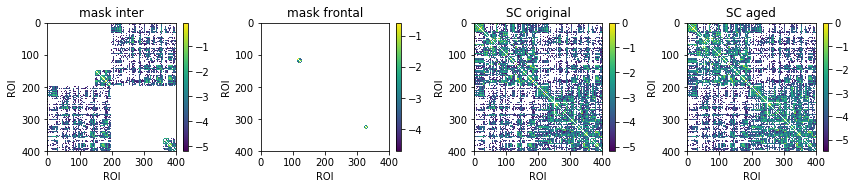

In [20]:
fig, axs = plt.subplots(ncols=4, figsize=(12,8))

ax = axs[0]
im = ax.imshow(np.log10(MaskJulichA))
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='mask inter', ylabel='ROI', xlabel='ROI')

ax = axs[1]
im = ax.imshow(np.log10(MaskJulichB))
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='mask frontal', ylabel='ROI', xlabel='ROI')


ax = axs[2]
im = ax.imshow(np.log10(SC_healthy))
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='SC original', ylabel='ROI', xlabel='ROI')

ax = axs[3]
im = ax.imshow(np.log10(SC_aged))
add_colorbar(fig, ax, im, size='4%', pad=0.1)
ax.set(title='SC aged', ylabel='ROI', xlabel='ROI')

fig.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCdata_log.png"))


### simulation set up

In [21]:
sim_len = 5; # 5 min simulation
sim_len = sim_len * 60; # convert to sec
input_freq = 10;
ti = 0;
skip_ = 10; # skip initial simulated time-points
h_Store = 0.05;
h = 0.005; # dt of MPR
tf = sim_len *(2*input_freq);
tf = (tf + skip_);
count_ = int(2*input_freq * h_Store/h); # downsampling rate in the function.

delta = 0.7;
eta = -4.6;
J = 14.5;
tau = 1;

nCoeff = 8; # usually it's integer. depending on the connectome, range is between 4 to 10

In [22]:
delta = 0.7;
eta = -4.6;
J = 14.5;
tau = 1;

In [23]:
G=.84

In [24]:
h, h_Store, sim_len, nCoeff, ti, tf, J, delta, G, eta, skip_, count_

(0.005, 0.05, 300, 8, 0, 6010, 14.5, 0.7, 0.84, -4.6, 10, 200)

### sanity check

In [25]:
start_time = time.time()
V,R = MPR(h, h_Store, sim_len, nCoeff, SC_aged, ti, tf, J, delta, G, eta, skip_, count_);
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 57.647814989089966


In [26]:
V.shape, R.shape

((6000, 400), (6000, 400))

In [27]:
ds=20

In [28]:
BOLD_v=V[::ds,:].T
BOLD_r=R[::ds,:].T

In [29]:
BOLD_v.shape, BOLD_r.shape

((400, 300), (400, 300))

In [30]:
nt = BOLD_v.shape[1]
nn = BOLD_v.shape[0]

nn, nt

(400, 300)

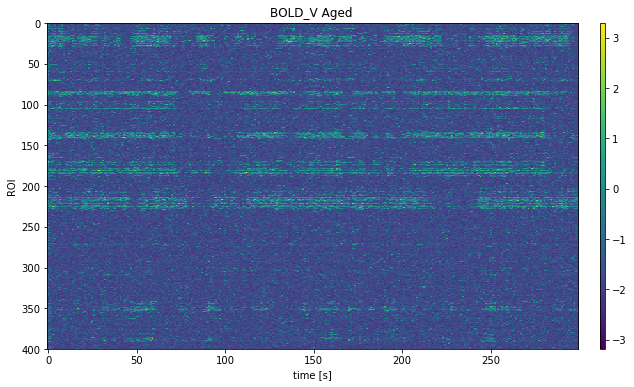

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(BOLD_v, aspect='auto', interpolation='none')
ax.set(xlabel='time [s]', ylabel='ROI', title='BOLD_V Aged ')
add_colorbar(fig,ax, im)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Imshow_BOLD_aged_v.png"))

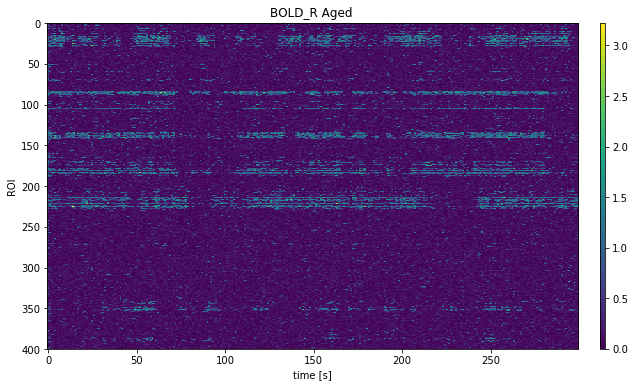

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(BOLD_r, aspect='auto', interpolation='none')
ax.set(xlabel='time [s]', ylabel='ROI', title='BOLD_R Aged ')
add_colorbar(fig,ax, im)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Imshow_BOLD_aged_r.png"))

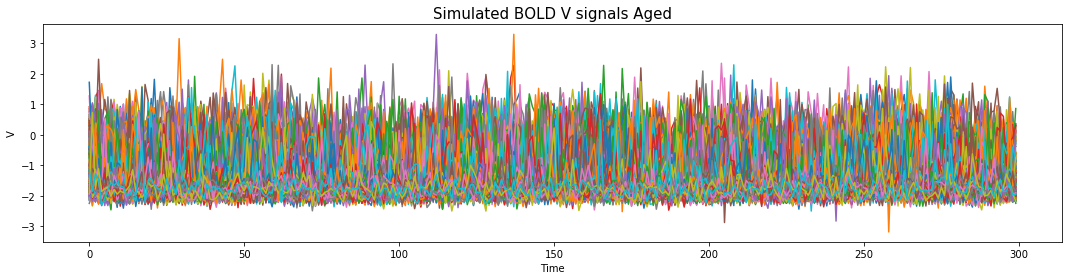

In [33]:
plt.figure(figsize=(15, 4))
plt.plot(BOLD_v.T)
plt.xlabel("Time")
plt.ylabel("V")
plt.title("Simulated BOLD V signals Aged",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLDdata_v_aged.png"))
plt.show()     

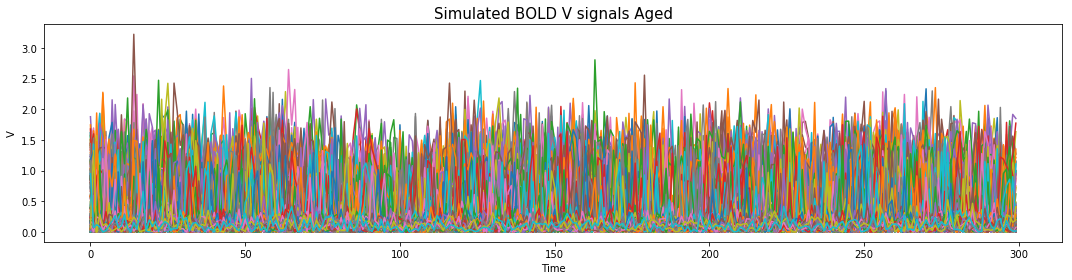

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(BOLD_r.T)
plt.xlabel("Time")
plt.ylabel("V")
plt.title("Simulated BOLD V signals Aged",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLDdata_v_aged.png"))
plt.show()     

### data features

In [35]:
FC_aged=np.corrcoef(BOLD_v)
FC_aged.shape

(400, 400)

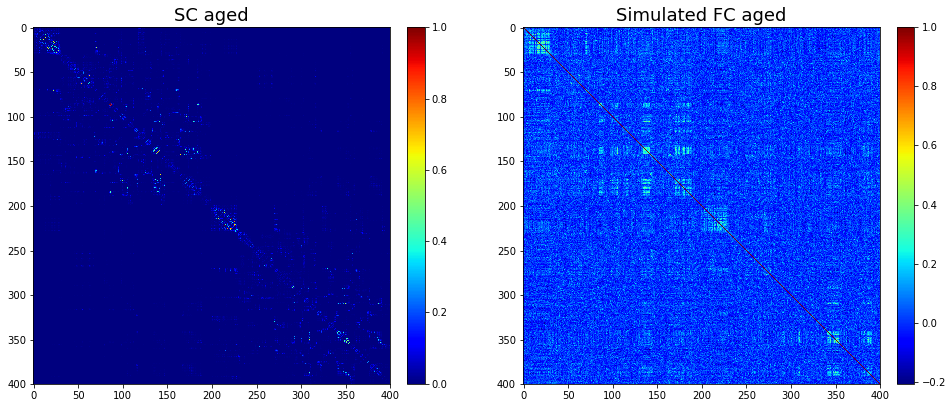

In [36]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow((SC_aged), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SC aged', fontsize=18)
plt.subplot(122)
im = plt.imshow(FC_aged,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Simulated FC aged', fontsize=18.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_FC_aged.png"))
plt.tight_layout(pad=2)
plt.show()

In [37]:
from sbi_julia import extract_FCD

In [38]:
BOLD_v.shape

(400, 300)

In [39]:
lenseries=len(BOLD_v[1])
lenseries

300

In [40]:
wwidth=30
maxNwindows=200
olap=0.96

# wwidth=30
# maxNwindows=200
# olap=0.94

In [41]:
Nwindows=min(((lenseries-wwidth*olap)//(wwidth*(1-olap)),maxNwindows))
shift=int((lenseries-wwidth)//(Nwindows-1))
if Nwindows==maxNwindows:
      wwidth=int(shift//(1-olap))
    
Nwindows, shift

(200, 1)

In [42]:
indx_start = range(0,(lenseries-wwidth+1),shift)
indx_stop = range(wwidth,(1+lenseries),shift)
indx_start, indx_stop

(range(0, 277), range(24, 301))

In [43]:
PcorrFCD_sim,Pcorr_sim,shift_sim=extract_FCD(BOLD_v,wwidth,maxNwindows,olap,mode='corr')

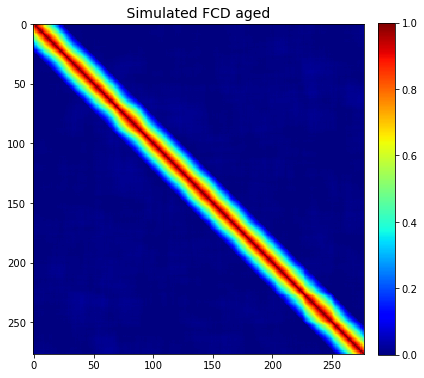

In [44]:
fig, ax =plt.subplots(figsize=(6, 6))
plt.imshow(PcorrFCD_sim, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(' Simulated FCD aged ', fontsize=14)
#plt.axis([0, 250, 250, 0]) 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"FCDSimulatedBOLD_v_aged.png"))
plt.show()

In [45]:
off_diag_sum_FC = np.sum(FC_aged) - np.trace(FC_aged)

off_diag_sum_FCD = np.sum(PcorrFCD_sim) - np.trace(PcorrFCD_sim)


In [46]:
off_diag_sum_FC, off_diag_sum_FCD, 

(1664.765976262387, 6158.602029631364)

In [47]:
from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode



from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

In [48]:
def calculate_summary_statistics(x, nn, features):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """
    
    X=x.reshape(nn, int(x.shape[0]/nn))

    n_summary = 16*nn+(nn*nn)+300*300

    wwidth=30
    maxNwindows=200
    olap=0.96
        
    sum_stats_vec = np.concatenate((np.mean(X, axis=1), 
                                    np.median(X, axis=1),
                                    np.std(X, axis=1),
                                    skew(X, axis=1), 
                                    kurtosis(X, axis=1),
                                    ))

    for item in features:

            if item is 'higher_moments':

                        sum_stats_vec = np.concatenate((sum_stats_vec,
                                                moment(X, moment=2, axis=1),
                                                moment(X, moment=3, axis=1),
                                                moment(X, moment=4, axis=1),     
                                                                   ))

            if item is 'FC_corr':

                        FC=np.corrcoef(X)
                        off_diag_sum_FC = np.sum(FC) - np.trace(FC)
                        #eigen_vals_FC, _ = LA.eig(FC)
                        #pca = PCA(n_components=3)
                        #PCA_FC = pca.fit_transform(FC)

                        sum_stats_vec = np.concatenate((sum_stats_vec,
                                        np.array([off_diag_sum_FC]),
                                                       ))

            if item is 'FCD_corr':

                        FCDcorr,Pcorr,shift=extract_FCD(X,wwidth,maxNwindows,olap,mode='corr')
                    
                        off_diag_sum_FCD = np.sum(FCDcorr) - np.trace(FCDcorr)
                        #eigen_vals_FCD, _ = LA.eig(FCDcorr)
                        #pca = PCA(n_components=3)
                        #PCA_FCD = pca.fit_transform(FCDcorr)
                        
                        sum_stats_vec = np.concatenate((sum_stats_vec,
                                        np.array([off_diag_sum_FCD]),
                                                       ))
            
    sum_stats_vec = sum_stats_vec[0:n_summary]        


    return sum_stats_vec


In [49]:
calculate_summary_statistics = numba.jit(calculate_summary_statistics)

In [50]:
_=calculate_summary_statistics(BOLD_v.reshape(-1), nn, features=['higher_moments', 'FC_corr', 'FCD_corr'])
_.shape

(3202,)

### sweep over alpha and G

In [51]:
#np.arange(0.0,1.0, 0.025).shape

In [52]:
# FCD_mean=np.zeros((40,40))
# FCD_mean.shape

In [53]:
# start_time = time.time()

# i=-1
# for alpha in np.arange(0.0,1.0, 0.025):
#     j=-1
#     i=i+1
#     for G in np.arange(0.0,2.0, 0.05):
#         j=j+1
#         #print('alpha=', alpha)
#         #print('G=',G)
#         SC_aged=SC_healthy-(alpha*MaskJulichA)-(beta*MaskJulichB)
#         V,R = MPR(h, h_Store, sim_len, nCoeff, SC_aged, ti, tf, J, delta, G, eta, skip_, count_);
#         BOLD_v=V[::ds,:].T

#         PcorrFCD_sim,Pcorr_sim,shift_sim=extract_FCD(BOLD_v,wwidth,maxNwindows,olap,mode='corr')
#         off_diag_sum_FCD = np.sum(PcorrFCD_sim) - np.trace(PcorrFCD_sim)

#         FCD_mean[i,j]=off_diag_sum_FCD
        
# print("  sweep (sec) takes:" , (time.time() - start_time))        

In [54]:
# fig, ax = plt.subplots(figsize=(10,6))
# im = ax.imshow(FCD_mean, aspect='auto', interpolation='none')
# ax.set(xlabel='G', ylabel='alpha', title='Sweep features')
# add_colorbar(fig,ax, im)
# plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Imshow_FCD_mean_sweep_alpha_G.png"))

In [55]:
#np.save(os.path.join(cwd, 'FCD_mean.npy') , FCD_mean)

### 1. Simulator wrapper

In [56]:
def MPR_simulator_wrapper(params):

    params = np.asarray(params)
    
    params_alpha=params[0]
    params_G=params[1]
    
    SC_aged_=SC_healthy-(params_alpha*MaskJulichA)-(beta*MaskJulichB)
    
    V_sim,R_sim = MPR(h, h_Store, sim_len, nCoeff, SC_aged_, ti, tf, J, delta, params_G, eta, skip_, count_);
    
    BOLD_v_sim=V_sim[::ds,:].T
    
    
    summstats = torch.as_tensor(calculate_summary_statistics(BOLD_v_sim.reshape(-1), nn, features=['higher_moments', 'FC_corr', 'FCD_corr']))

    return summstats 

### 2. Prior over model parameters

In [57]:
prior_min_alpha=0.
prior_min_G=0*np.ones(1)

prior_max_alpha=1.
prior_max_G=1.5*np.ones(1)

In [58]:
prior_min=np.hstack([prior_min_alpha, prior_min_G])
prior_max=np.hstack([prior_max_alpha, prior_max_G])


In [59]:
prior_min.shape, prior_max.shape

((2,), (2,))

In [60]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### 3. Inference

In [61]:
start_time = time.time()

posterior = infer(MPR_simulator_wrapper, prior, method='SNPE',  num_simulations=1000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 39 epochs.
------------------------------------------------------------
--- 49261.01241064072 seconds ---


### Data #1

In [171]:
alpha_true=0.5
beta_true =0.0
G_true=0.84#

In [172]:
labels_params = [r'$\alpha$', r'$G$']

In [173]:
params_true = np.hstack([alpha_true, G_true])

In [65]:
SC_aged_true=SC_healthy-(alpha_true*MaskJulichA)-(beta_true*MaskJulichB)

In [66]:
V_true, R_true = MPR(h, h_Store, sim_len, nCoeff, SC_aged_true, ti, tf, J, delta, G_true, eta, skip_, count_);

In [67]:
BOLD_obs=V_true[::ds,:].T

In [68]:
obs_summary_statistics=calculate_summary_statistics(BOLD_obs.reshape(-1), nn, features=['higher_moments', 'FC_corr', 'FCD_corr'])


In [69]:
BOLD_obs.shape, obs_summary_statistics.shape

((400, 300), (3202,))

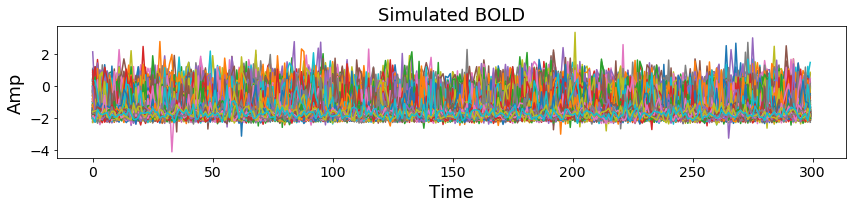

In [70]:
plt.figure(figsize=(12,3))
plt.plot(BOLD_obs.T)
plt.title("Simulated BOLD",fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Amp',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SimulatedBOLD_obs1.png"))
plt.show()

In [71]:
FC_obs=np.corrcoef(BOLD_obs)
FC_obs.shape

(400, 400)

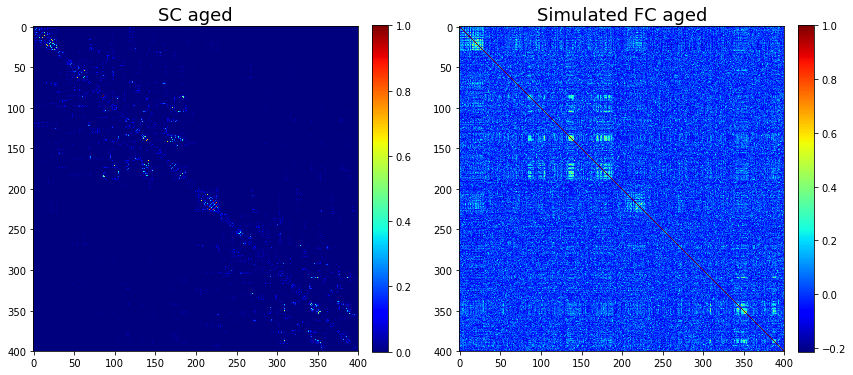

In [72]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow((SC_aged_true), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SC aged', fontsize=18)
plt.subplot(122)
im = plt.imshow(FC_obs,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Simulated FC aged', fontsize=18.0)
plt.savefig(os.path.join(Res_dir, "Sim_BOLD_FC_obs1.png"))
plt.show()

In [73]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

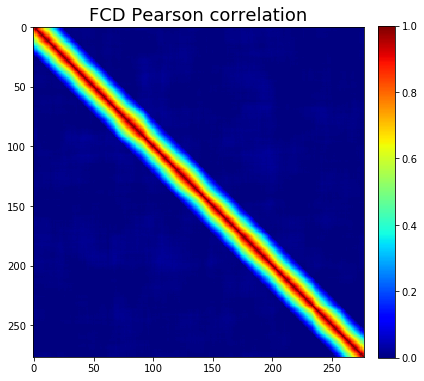

In [74]:
plt.figure(figsize=(6, 6))
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('FCD Pearson correlation', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir, "Sim_BOLD_FCD_obs1.png"))
plt.show()

### Posterior Data #1

In [75]:
nn

400

In [76]:
num_samples=1000

In [77]:
posterior_samples = posterior.sample((num_samples,), obs_summary_statistics, sample_with_mcmc=True,).numpy()

Generating samples: 100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


In [79]:
posterior_samples.shape, params_true.shape

((1000, 2), (2,))

In [80]:
np.save(os.path.join(Res_dir, 'posterior_samples_MPR_aged_obs1.npy') , posterior_samples)

In [81]:
params_true

array([0.5 , 0.84])

In [82]:
alpha_posterior=posterior_samples[:,0]
G_posterior=posterior_samples[:,1]

In [155]:
alpha_true, G_true

(0.5, 0.84)

In [156]:
alpha_posterior.mean(), G_posterior.mean()

(0.4797093, 0.8368705)

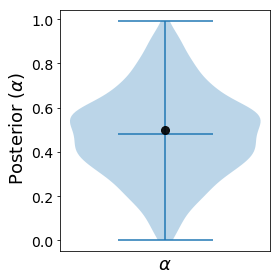

In [91]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(alpha_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[0] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(\alpha)}$', fontsize=18);  
plt.xlabel(r'${\alpha}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_InferredAlpha_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_InferredAlpha_obs1.eps"), doi=800)
plt.show()

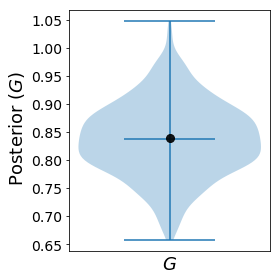

In [92]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_InferredG_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_InferredG_obs1.eps"), doi=800)
plt.show()

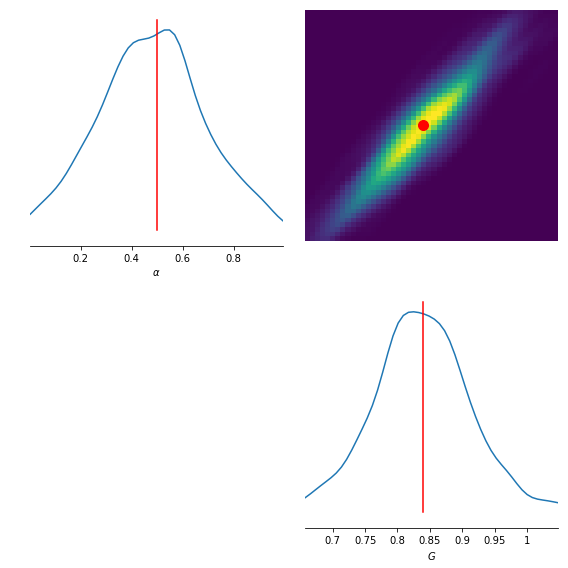

In [175]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=params_true,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_AlphaG_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_AlphaG_0bs1.eps"), doi=800) 
plt.show()

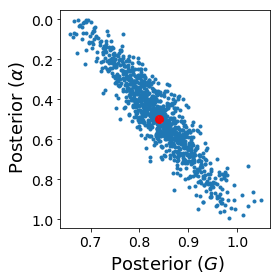

In [100]:
plt.figure(figsize=(4,4))
plt.plot(G_posterior, alpha_posterior, '.')
plt.plot(params_true[1],params_true[0] ,'o', color='r', alpha=0.9, markersize=8)
plt.xlabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.ylabel(' Posterior ' +r'${(\alpha)}$', fontsize=18);  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_InferredAlphaG_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_InferredAlphaG_obs1.eps"), doi=800)
plt.show()

In [124]:
G_posterior.shape

(1000,)

In [133]:
reg=linear_model.LinearRegression()
reg.fit(G_posterior.reshape((-1,1)),alpha_posterior.reshape((-1,1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [134]:
m=reg.coef_[0]
b=reg.intercept_
print("slope=",m, "intercept=",b)

slope= [2.731544] intercept= [-1.8062392]


In [146]:
predicted_alpha = regr.predict(G_posterior.reshape((-1,1)))

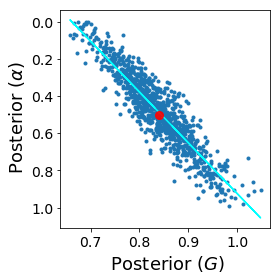

In [152]:
plt.figure(figsize=(4,4))
plt.plot(G_posterior, alpha_posterior, '.')
plt.plot(G_posterior, predicted_alpha, 'cyan')
plt.plot(params_true[1],params_true[0] ,'o', color='r', alpha=0.9, markersize=8)
plt.xlabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.ylabel(' Posterior ' +r'${(\alpha)}$', fontsize=18);  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_LinregInferredAlphaG_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_LinregInferredAlphaG_obs1.eps"), doi=800)
plt.show()

In [101]:
alpha_posterior.mean(), G_posterior.mean()

(0.4797093, 0.8368705)

In [102]:
SC_aged_posterior=SC_healthy-(alpha_posterior.mean()*MaskJulichA)-(beta_true*MaskJulichB)

In [112]:
V_fit, R_fit = MPR(h, h_Store, sim_len, nCoeff, SC_aged_posterior, ti, tf, J, delta, G_posterior.mean(), eta, skip_, count_);

In [113]:
BOLD_fit=V_fit[::ds,:].T

In [114]:
np.save(os.path.join(Res_dir, 'BOLD_obs_MPR_aged_obs1.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit_MPR_aged_obs1.npy') , BOLD_fit)

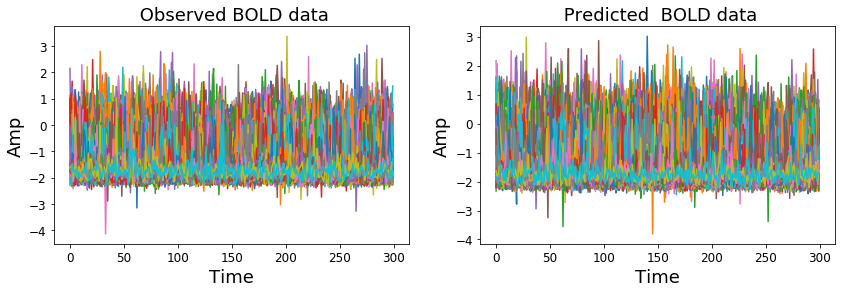

In [115]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.plot(BOLD_obs.T)
plt.xlabel("Time", fontsize=18);
plt.ylabel("Amp", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(" Observed BOLD data", fontsize=18) 


plt.subplot(122)
plt.plot(BOLD_fit.T)
plt.xlabel("Time", fontsize=18);
plt.ylabel("Amp", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(" Predicted  BOLD data", fontsize=18) 
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_FittedSeriesobservation_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_FittedSeriesobservation_obs1.eps"), doi=800)
plt.show()

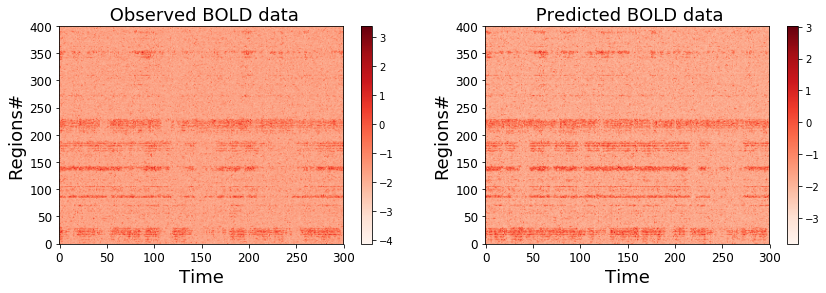

In [116]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(" Observed BOLD data", fontsize=18) 

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.xlabel("Time", fontsize=18);
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(" Predicted BOLD data", fontsize=18) 
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_ImshowFittedobservation_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_MPR_aged_ImshowFittedobservation_obs1.eps"), doi=800)
plt.show()

In [117]:
FC_obs=np.corrcoef(BOLD_obs)
FC_fit=np.corrcoef(BOLD_fit)

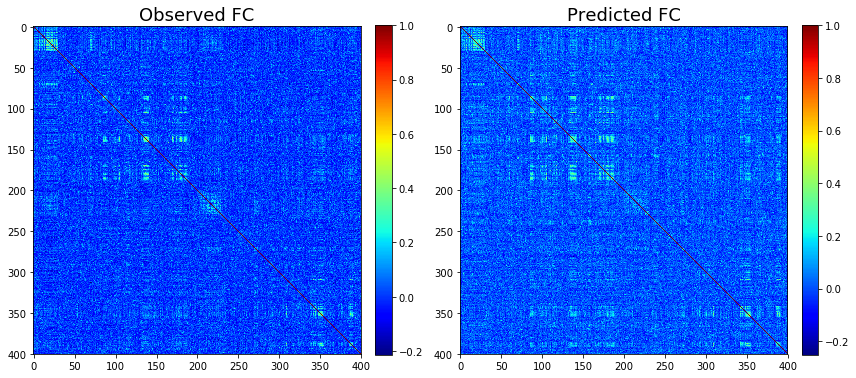

In [118]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FC_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.tight_layout()
plt.subplot(122)
im = plt.imshow(FC_fit,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.eps"), doi=800)
plt.show()

In [119]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

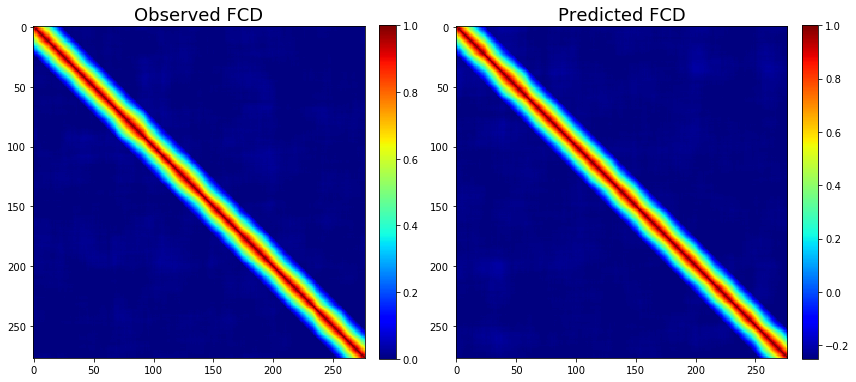

In [120]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.tight_layout()
plt.subplot(122)
plt.imshow(FCDcorr_fit, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.eps"), doi=800)
plt.show()